# Assignment 4: Attention
- In this assignment, you have to implement the attention mechanism for the machine translation task.

- Problems
  - 1. Implement Dot Product Attention (10 pts)
  - 2. Implement Attention in Batch (12 pts)
  - 3. Implement Seq2seq with Attention (14 pts)
  - 4. Implement Transformer-like Attention (14 pts)
    - Self-attention
    - Cross-attention

- Submission
  - You have to copy and paste your answer to ``NLP_Assignment_4.py`` file and submit it to Cyber Campus
    - Submssion file name has to be ``NLP_Assignment_4_{your_student_id}.py``
    - { } character is just placeholder, so don't inlcude it in your filename.

- CAUTION:
  - You have to implement most of the functions with **vectorized matrix multiplication**, not with for loop



- If you find any error, please do not hesitate to report or make a question on Cyber Campus
    - Don't waste too much time on solving the error. The code is not thoroughly checked, and the error can be not your fault.

In [ ]:
# If you are in Colab, install transformers
!pip -q install transformers
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 6.7 MB/s eta 0:00:00


In [ ]:
# Download the py file for submission
!wget https://raw.githubusercontent.com/jdasam/aat3020/main/NLP_Assignment_4.py
!wget https://raw.githubusercontent.com/jdasam/aat3020/main/assignment4_pre_defined.py

--2024-06-26 09:32:26--  https://raw.githubusercontent.com/jdasam/aat3020/main/NLP_Assignment_4.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41850 (41K) [text/plain]
Saving to: ‘NLP_Assignment_4.py’

NLP_Assignment_4.py 100%[===================>]  40.87K  --.-KB/s    in 0.01s   

2024-06-26 09:32:26 (3.48 MB/s) - ‘NLP_Assignment_4.py’ saved [41850/41850]

--2024-06-26 09:32:26--  https://raw.githubusercontent.com/jdasam/aat3020/main/assignment4_pre_defined.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13768 (13K) [text/

In [ ]:
import torch
import torch.nn as nn
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import koreanize_matplotlib
import numpy as np

from torch.nn.utils.rnn import PackedSequence, pad_sequence, pack_sequence, pad_packed_sequence, pack_padded_sequence
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast

import os

# Below helps to run tokenizer with multiprocessing
os.environ["TOKENIZERS_PARALLELISM"] = "true"

#### Vectorization

In [ ]:
'''
This is the example of vectorization of dot product for two different sequence length.
'''

e_states = torch.randn(100, 16)
d_states = torch.randn(80, 16)

dot_product = torch.mm(e_states, d_states.permute(1,0)) # (100, 16) x (16, 80) = (100, 80)
dot_product

tensor([[ 0.6500, -4.2786,  1.2358,  ..., -6.6063,  4.3687,  2.4036],
        [ 2.3086,  3.3307,  0.1186,  ..., -0.2289, -1.8618, -1.9732],
        [ 1.4200, -9.4868,  0.0942,  ...,  5.3254, -0.9110, -1.3864],
        ...,
        [-0.3171, -2.3594, -0.6865,  ..., -0.5154,  2.3111,  0.1890],
        [ 2.0520,  6.1466, -6.2863,  ...,  0.3353, -6.4856,  0.6394],
        [ 1.7735, -3.4298,  4.5868,  ...,  0.2979, -2.8560,  0.5707]])

## Problem 1: Implement Dot Product Attention

- Optimizing computation time is really important
    - Use `torch.mm()` or `torch.matmul()`
    - `torch.mm(a, b)` is a function for calculating matrix multiplcation of two matrices `a` and `b`
        - `a` and `b` has to be 2-dim tensors
        - `a.shape[1]` has to be equal to `b.shape[0]`
    - `torch.matmul()` is a function for matrix multiplication but with broadcasting
        - https://pytorch.org/docs/stable/generated/torch.matmul.html
        - It has less restriction on its input shape.
            - It automatically matches the dimension of two tensors following some rules
            - Therefore, it is a bit risky to use this funciton if you don't understand how it works
- **DO NOT** use element-wise product or for loop!

### Hint: Dot product as matrix multiplcation.

- Let's say there are two vector, $u=\begin{bmatrix}-3 \\ 2 \\ 1\end{bmatrix}$ and $v = \begin{bmatrix} 5 \\ 4 \\ 6\end{bmatrix}$
    - The dot product of the two vectors is $(-3 \times 5) + (2 \times 4) + (1 \times 6) = 1$
    - It is equivalent to $u^T \times v$
        - In this case $u\in\mathbb{R}^{3\times1}$ and $v\in\mathbb{R}^{3\times1}$
- In PyTorch, this can be described as below:
    - `u = torch.Tensor([-3, 2, 1])`
    - `v = torch.Tensor([5, 4, 6])`
    - Dot product of u and v can be calculated by one of belows:
        - `torch.mm(u.unsqueeze(0), v.unsqueeze(1))`
            - `u.unsqueeze(0).shape == [1, 3]`
            - `v.unsqueeze(1).shape == [3, 1]`
            - `unsqueeze()` returns a new tensor with a dimension of size one inserted at the specified position.
            - The result has shape of [1,1]
        - `torch.matmul(u, v)`
        - `u @ v`
            - `@` denotes matrix multiplication, which was introduced from Python 3.5
        - `(u * v).sum()`
            - This will be much slower than others, because it first do element-wise multiplcation

In [ ]:
'''
Hint: Dot product as matrix multiplcation.
'''

u = torch.Tensor([-3, 2, 1])
v = torch.Tensor([5, 4, 6])

print(f"Result of (u * v).sum() is {(u * v).sum()}. This computation is much slower than others because it use element-wise multiplication instead of matrix multiplication")
print(f"Result of torch.mm(u.unsqueeze(0), v.unsqueeze(1)) is {torch.mm(u.unsqueeze(0), v.unsqueeze(1))}")
print(f"Result of torch.matmul(u, v) is {torch.matmul(u, v)}")
print(f"Result of u @ v is {u @ v}")

Result of (u * v).sum() is -1.0. This computation is much slower than others because it use element-wise multiplication instead of matrix multiplication
Result of torch.mm(u.unsqueeze(0), v.unsqueeze(1)) is tensor([[-1.]])
Result of torch.matmul(u, v) is -1.0
Result of u @ v is -1.0


### 1-1 Get attention score with dot product (4 pts)
- From a sequence of key and a single query

In [ ]:
def get_attention_score_for_a_single_query(keys, query):
  '''
  This function returns an attention score for each vector in keys for a given query.
  You can regard 'keys' as hidden states over timestep of Encoder, while query is a hidden state of specific time step of Decoder
  Name 'keys' are used because it is used for calculating attention score (match rate between given vector and query).

  For every C-dimensional vector key, the attention score is a dot product between the key and the query vector.

  Arguments:
    keys (torch.Tensor): Has a shape of [T, C]. These are vectors that a query wants attend to
    query (torch.Tensor): Has a shape of [C]. This is a vector that attends to other set of vectors (keys and values)

  Output:
    attention_score (torch.Tensor): The attention score in real number that represent how much does query have to attend to each vector in keys
                                    Has a shape of [T]

    attention_score[i] has to be a dot product value between keys[i] and query


  TODO: Complete this sentence using torch.mm (matrix multiplication)
  Hint: You can use atensor.unsqueeze(dim) to expand a dimension (with a diemsion of length 1) without changing item value of the tensor.
  '''

  attention_scores= torch.mm(keys, query.unsqueeze(-1)).squeeze(-1)

  return attention_scores


torch.manual_seed(0)
num_t = 23
h_size = 16

keys = torch.randn(num_t, h_size)
query = torch.randn(h_size)

att_score = get_attention_score_for_a_single_query(keys, query)
att_score

tensor([-3.0786,  2.1729,  1.7950, -5.0503,  3.3254,  0.2828, -0.9800, -1.8868,
         0.2550,  2.9389, -0.1799, -1.0586,  0.1465, -0.9441,  0.8888, -3.8108,
        -2.5662, -1.1660, -2.2327,  2.7087, -0.5800,  8.7984,  4.3816])

In [ ]:
'''
Test Case
'''
assert att_score.ndim == 1 and len(att_score) == num_t, "Error: Check output shape"
answer = torch.Tensor([-3.0786,  2.1729,  1.7950, -5.0503,  3.3254,  0.2828, -0.9800, -1.8868,
         0.2550,  2.9389, -0.1799, -1.0586,  0.1465, -0.9441,  0.8888, -3.8108,
        -2.5662, -1.1660, -2.2327,  2.7087, -0.5800,  8.7984,  4.3816])
assert torch.allclose(att_score, answer, atol=1e-4) , "Error: The output value is different"
print("Passed all the cases!")

Passed all the cases!


### 1-2 Get attention weight from score (2pts)
- Convert attention score to attention weight
- Use softmax function

In [ ]:
def get_attention_weight_from_score(attention_score):
  '''
  This function converts attention score to attention weight.

  Argument:
    attention_score (torch.Tensor): Tensor of real number. Has a shape of [T]

  Output:
    attention_weight (torch.Tensor): Tensor of real number between 0 and 1. Sum of attention_weight is 1. Has a shape of [T]

  TODO: Complete this function
  '''
  assert attention_score.ndim == 1

  attention_weight = torch.softmax(attention_score, dim=0)
  return attention_weight

att_weight = get_attention_weight_from_score(att_score)
att_weight

tensor([6.7782e-06, 1.2936e-03, 8.8653e-04, 9.4370e-07, 4.0957e-03, 1.9541e-04,
        5.5277e-05, 2.2321e-05, 1.9005e-04, 2.7829e-03, 1.2303e-04, 5.1099e-05,
        1.7052e-04, 5.7296e-05, 3.5821e-04, 3.2593e-06, 1.1314e-05, 4.5893e-05,
        1.5795e-05, 2.2107e-03, 8.2463e-05, 9.7556e-01, 1.1777e-02])

In [ ]:
answer = torch.Tensor([0.0000,     0.0013,     0.0009,     0.0000,     0.0041,     0.0002,
            0.0001,     0.0000,     0.0002,     0.0028,     0.0001,     0.0001,
            0.0002,     0.0001,     0.0004,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0022,     0.0001,     0.9756,     0.0118])
assert att_weight.shape == att_score.shape, 'Shape has to be remained the same'
assert att_weight.sum() == 1, "Sum of attention weight has to be 1"
assert torch.allclose(att_weight, answer, atol=1e-4) , "Error: The output value is different"

print("Passed all the cases!")


Passed all the cases!


### 1-3 Get weighted sum (4 pts)
- Using attention weight and values, get the weighted sum

In [ ]:
def get_weighted_sum(values, attention_weight):
  '''
  This function converts attention score to attention weight

  Argument:
    values (torch.Tensor): Has a shape of [T, C]. These are vectors that are used to form attention vector
    attention_weight: Has a shape of [T], which represents the weight for each vector to compose the attention vector

  Output:
    attention_vector (torch.Tensor): Weighted sum of values using the attention weight. Has a shape of [C]

  TODO: Complete this function using torch.mm
  '''

  attention_weight = attention_weight.unsqueeze(1)
  attention_vector = torch.mm(values.t(), attention_weight).squeeze(-1)
  return attention_vector



att_vec = get_weighted_sum(keys, att_weight) # In simple dot-product-attention, key and value are the same
att_vec

tensor([ 0.6280,  3.8540, -0.1042,  0.3148,  0.3711, -0.5095, -0.9663,  1.3295,
         1.9003, -1.2611, -2.2939, -2.0338,  0.8757, -0.6726,  1.9071, -1.0711])

In [ ]:
answer = torch.Tensor([ 0.6280,  3.8540, -0.1042,  0.3148,  0.3711, -0.5095, -0.9663,  1.3295,
         1.9003, -1.2611, -2.2939, -2.0338,  0.8757, -0.6726,  1.9071, -1.0711])
assert att_vec.shape == query.shape, 'Shape has to be remained the same'
assert torch.allclose(att_vec, answer, atol=1e-4) , "Error: The output value is different"
print("Passed all the cases")


Passed all the cases


## Problem 2: Attention in Batch ( 16 pts)
- In this problem, you have to calculate attention with batch
- You can use `torch.bmm()` for batch matrix multiplication https://pytorch.org/docs/stable/generated/torch.bmm.html
    - `torch.bmm()` takes two 3-dim tensor as its input
    - Each tensor has to be 3-dim (atensor.ndim==3)


In [ ]:
'''
Hint for Problem 2

You can calculate matrix multiplication of matrices in batch effectively using torch.bmm() or torch.matmul()
'''

torch.manual_seed(0)
matrix_left1 = torch.randn(5, 3)
matrix_left2 = torch.randn(5, 3)

print(f"matrix_left1: \n{matrix_left1}")
print(f"matrix_left2: \n{matrix_left2}")

matrix_right1 = torch.randn(3, 4)
matrix_right2 = torch.randn(3, 4)
print(f"matrix_right1: \n{matrix_right1}")
print(f"matrix_right2: \n{matrix_right2}")

print("Let's assume that we have batch of matrix, which is stack of these two matices")
matrix_left = torch.stack([matrix_left1, matrix_left2])
matrix_right = torch.stack([matrix_right1, matrix_right2])

print(f"matrix_left: \n{matrix_left} \n which is shape of {matrix_left.shape}")
print(f"matrix_right: \n{matrix_right}\n which is shape of {matrix_right.shape}")


'''
Exhaustive method: using torch.mm() only with for loop (This is SLOW when matrix gets much larger)
'''

mm_forloop_output = []
for sample_index in range(matrix_left.shape[0]):
  mat_left = matrix_left[sample_index]
  mat_right = matrix_right[sample_index]

  mm_result = torch.mm(mat_left, mat_right)
  mm_forloop_output.append(mm_result)

mm_forloop_stack = torch.stack(mm_forloop_output)
print(f"mat_mul_stack: \n{mm_forloop_stack}\n which is shape of {mm_forloop_stack.shape}")


'''
Good method: using torch.bmm()
'''

mat_mul_bmm = torch.bmm(matrix_left, matrix_right)
print(f"mat_mul_bmm: \n{mat_mul_bmm}\n which is shape of {mat_mul_bmm.shape}")


matrix_left1: 
tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193],
        [-0.4033, -0.5966,  0.1820],
        [-0.8567,  1.1006, -1.0712]])
matrix_left2: 
tensor([[ 0.1227, -0.5663,  0.3731],
        [-0.8920, -1.5091,  0.3704],
        [ 1.4565,  0.9398,  0.7748],
        [ 0.1919,  1.2638, -1.2904],
        [-0.7911, -0.0209, -0.7185]])
matrix_right1: 
tensor([[ 0.5186, -1.3125,  0.1920,  0.5428],
        [-2.2188,  0.2590, -1.0297, -0.5008],
        [ 0.2734, -0.9181, -0.0404,  0.2881]])
matrix_right2: 
tensor([[-0.0075, -0.9145, -1.0886, -0.2666],
        [ 0.1894, -0.2190,  2.0576, -0.0354],
        [ 0.0627, -0.7663,  1.0993,  2.7565]])
Let's assume that we have batch of matrix, which is stack of these two matices
matrix_left: 
tensor([[[ 1.5410, -0.2934, -2.1788],
         [ 0.5684, -1.0845, -1.3986],
         [ 0.4033,  0.8380, -0.7193],
         [-0.4033, -0.5966,  0.1820],
         [-0.8567,  1.1006, -1.0712]],

   

### 2-1 Get attention score in batch (4 pts)
- Now keys and query exist in batch

In [ ]:
def get_attention_score_for_a_batch_query(keys, query):
  '''
  This function returns a batch of attention score for each vector in (multi-batch) keys for a given (single-batch) query.
  You can regard 'keys' as hidden states over timestep of Encoder, while query is a hidden state of specific time step of Decoder
  Name 'keys' are used because it is used for calculating attention score (match rate between given vector and query).

  For every C-dimensional vector key, the attention score is a dot product between the key and the query vector.

  Arguments:
    keys (torch.Tensor): Has a shape of [N, T, C]. These are vectors that a query wants attend to
    query (torch.Tensor): Has a shape of [N, C]. This is a vector that attends to other set of vectors (keys and values)

  Output:
    attention_score (torch.Tensor): The attention score in real number that represent how much does query have to attend to each vector in keys
                                    Has a shape of [N, T]

    attention_score[n, i] has to be a dot product value between keys[n, i] and query[n]

  TODO: Complete this function without using for loop
  Hint: Use torch.bmm or torch.matmul after make two input tensors as 3-dim tensors.

  '''

  attention_scores = torch.bmm(keys, query.unsqueeze(2)).squeeze()
  return attention_scores

torch.manual_seed(0)
num_b = 6
num_t = 23
h_size = 16

keys = torch.randn(num_b,num_t, h_size)
query = torch.randn(num_b, h_size)
out = get_attention_score_for_a_batch_query(keys, query)


In [ ]:
'''
Test cases
'''

answer = torch.tensor([ -2.7744,   1.3793,   5.0969,   0.7559,   2.5898,  -0.9475,  -1.1960,
           5.4975,   0.4018,   5.9949,  -5.9428,  -0.4441,   0.6729,  -0.8326,
           3.7091,   1.4913,   2.2062,  -0.2244,  -4.0612,   2.9037,  10.6111,
           4.1383,  -4.6549])

assert out.ndim == 2 and out.shape == torch.Size([num_b, num_t]), "Error: Check output shape"
assert torch.allclose(out[2], answer, atol=1e-4), "Error: The output value is different"
print("Passed all the cases!")

Passed all the cases!


### 2-2 Get attention score in batch (4 pts)
- Implement the same function but in batchified queries

In [ ]:
def get_attention_score_for_a_batch_multiple_query(keys, queries):
  '''
  Now you have to implement the attention score for not only single query, but multiple queries.

  This function returns a batch of attention score for each vector in keys for given queries.
  You can regard 'keys' as hidden states over timestep of Encoder, while querys are hidden states over timestep of Decoder
  Name 'keys' are used because it is used for calculating attention score (match rate between given vector and query).

  For every C-dimensional vector key, the attention score is a dot product between the key and the query vector.

  Arguments:
    keys (torch.Tensor): Has a shape of [N, Ts, C]. These are vectors that a query wants attend to
    queries (torch.Tensor): Has a shape of [N, Tt, C]. This is a vector that attends to other set of vectors (keys and values)

  Output:
    attention_score (torch.Tensor): The attention score in real number that represent how much does query have to attend to each vector in keys
                                    Has a shape of [N, Ts, Tt]

    attention_score[n, i, t] has to be a dot product value between keys[n, i] and query[n, t]

  TODO: Complete this function without using for loop
  HINT: Use torch.bmm() with proper transpose (permutation) of given tensors. (You can use atensor.permute())
        Think about which dimension (axis) of tensors has to be multiplied together and resolved (disappear) after matrix multiplication,
        and how the result tensor has to look like (shape)
  '''

  attention_scores = torch.bmm(keys, queries.permute(0, 2, 1))
  return attention_scores

torch.manual_seed(0)
num_b = 6
num_ts = 23
num_tt = 14
h_size = 16

keys = torch.randn(num_b, num_ts, h_size)
queries = torch.randn(num_b, num_tt, h_size)
att_score = get_attention_score_for_a_batch_multiple_query(keys, queries)

att_score

tensor([[[  6.1462,   2.7917,   3.2981,  ...,  -1.7558,  -1.9945,   1.7817],
         [ -2.0761,   1.5621,  -4.6314,  ...,  -2.9616,   5.0151,  -0.5098],
         [ -3.7923,   0.6755,  -2.5517,  ...,  -6.6489,   2.2012,   0.5882],
         ...,
         [  2.9819,  12.6860,   6.7435,  ...,   3.5522,  -7.0258,   2.3800],
         [ -5.4682,  -2.9139,  -0.3054,  ...,   6.4960,  -1.4581, -12.5525],
         [ -1.0037,   1.1092,   1.3248,  ...,   2.8827,   3.8804,  -5.4968]],

        [[ -2.9907,  -0.1470,  -0.1703,  ...,   2.4992,  -1.8304,   1.1768],
         [-15.4518,   2.2430,   4.9486,  ...,   4.4271,  -4.3865,  -9.2907],
         [  4.2723,  -0.6171,   2.6252,  ...,  -2.2281,  -2.5648,  -4.1481],
         ...,
         [  1.3169,  -1.1141,  -1.6058,  ...,   1.9466,   2.6665,  -4.1625],
         [ -7.9481,   5.0494,   0.7725,  ...,   0.5016,  -3.3123,  -7.8802],
         [  1.8112,  -3.9315,   1.6521,  ...,  -0.2215,  -0.1541,  -6.4050]],

        [[ -3.0427,   1.6135,  -0.4640,  ...

In [ ]:
'''
Test cases
'''
answer = torch.Tensor([ 4.9620, -9.6091, -4.9472,  1.4543, -5.6273,  9.1436,  1.4172,  0.0464,
        -5.7033,  4.5473,  7.7498,  1.3405, -3.1877,  2.8759])
answer2 = torch.Tensor([[ 2.5171,  0.6216,  3.7929,  2.6163,  5.3290,  0.3592,  2.3067, -0.1099,
         1.8963,  0.4175, -1.4283,  1.4388, -2.7825, -1.3690, -1.9615, -1.9514,
        -6.4635,  1.9574,  0.1868,  8.5354,  4.6053,  2.8786, -2.1453]])
assert att_score.ndim == 3 and att_score.shape == torch.Size([num_b, num_ts, num_tt]), 'Check the output shape'
assert torch.allclose(att_score[2,4], answer, atol=1e-4), 'Calculated result is wrong'
assert torch.allclose(att_score[3,:,2], answer2, atol=1e-4),  'Calculated result is wrong'

print("Passed all the cases!")

Passed all the cases!


### 2-3 Get Masked Softmax (4 pts)
- Implement masked softmax

In [ ]:
def get_masked_softmax(attention_score, mask):
  '''
  During the batch computation, each sequence in the batch can have different length.
  To group them as in a single tensor, we usually pad values

  Arguments:
    attention_score (torch.Tensor): The attention score in real number that represent how much does query have to attend to each vector in keys
                                    Has a shape of [N, Ts, Tt]
    mask (torch.Tensor): Boolean tensor with a shape of [N, Ts] that represents whether the corresponding is valid or not.
                         mask[n, t] == 1 if and only if input_batch[n,t] is not a padded value.
                         If input_batch[n,t] is a padded value, then mask[n,t] == 0

  Output:
    attention_weight (torch.Tensor): The attention weight in real number between 0 and 1. The sum of attention_weight along keys timestep dimension is 1.
                                    Has a shape of [N, Ts, Tt]

    attention_weight[n, i, t] has to be an attention weight of values[n, i] for queries[n, t]

  TODO: Complete this function without using for loop
  Hint: You can give -infinity value by -float("inf")

  '''
  mask = mask.unsqueeze(-1).expand(-1, -1, attention_score.size()[2])
  attention_score_masked = attention_score.masked_fill(mask == 0, -float("inf"))
  attention_weight = torch.softmax(attention_score_masked, dim=1)

  return attention_weight


'''
Don't change this codes
'''
mask = torch.ones_like(att_score)[..., 0]
mask[4, 15:] = 0
mask[5, 17:] = 0
att_score_modified = att_score.clone()
att_score_modified[4, 15:] = 0
attention_weight = get_masked_softmax(att_score, mask)
attention_weight_for_modified = get_masked_softmax(att_score_modified, mask)
attention_weight, attention_weight_for_modified

(tensor([[[8.5095e-02, 5.0265e-05, 2.6409e-02,  ..., 1.8632e-04,
           4.1884e-05, 1.4554e-03],
          [2.2856e-05, 1.4698e-05, 9.5063e-06,  ..., 5.5794e-05,
           4.6370e-02, 1.4716e-04],
          [4.1080e-06, 6.0563e-06, 7.6066e-05,  ..., 1.3970e-06,
           2.7809e-03, 4.4123e-04],
          ...,
          [3.5946e-03, 9.9608e-01, 8.2803e-01,  ..., 3.7625e-02,
           2.7350e-07, 2.6474e-03],
          [7.6878e-07, 1.6724e-07, 7.1906e-04,  ..., 7.1448e-01,
           7.1609e-05, 8.6639e-10],
          [6.6794e-05, 9.3445e-06, 3.6707e-03,  ..., 1.9264e-02,
           1.4910e-02, 1.0046e-06]],
 
         [[1.4556e-06, 7.2275e-05, 8.3620e-06,  ..., 7.2220e-02,
           2.6008e-04, 2.2393e-03],
          [5.6399e-12, 7.8883e-04, 1.3978e-03,  ..., 4.9651e-01,
           2.0184e-05, 6.3696e-08],
          [2.0765e-03, 4.5171e-05, 1.3690e-04,  ..., 6.3913e-04,
           1.2479e-04, 1.0902e-05],
          ...,
          [1.0810e-04, 2.7478e-05, 1.9901e-06,  ..., 4.155

In [ ]:
answer = torch.Tensor([0.0120,     0.0002,     0.0901,     0.0003,     0.0259,     0.0036,
            0.5617,     0.0108,     0.2508,     0.0054,     0.0001,     0.0010,
            0.0000,     0.0005,     0.0375,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000])
assert torch.allclose(attention_weight[4,:,3], answer, atol=1e-4), 'Calculated result is wrong'
assert torch.allclose(attention_weight.sum(1),  torch.tensor([1.0]) , atol=1e-6 ), 'Sum of attention weight has to be 1'
assert torch.allclose(attention_weight, attention_weight_for_modified), "Output is different even though only masked part is different"
print("Passed all the cases!")

Passed all the cases!


### 2-4 Implement weighted sum in batchified version (4 pts)


In [ ]:
def get_batch_weighted_sum(values, attention_weight):
  '''
  This function converts attention score to attention weight

  Argument:
    values (torch.Tensor): Has a shape of [N, Ts, C]. These are vectors that are used to form attention vector
    attention_weight: Has a shape of [N, Ts, Tt], which represents the weight for each vector to compose the attention vector
                      attention_weight[n, s, t] represents weight for value[n, s] that corresponds to a given query, queries[n, t]

  Output:
    attention_vector (torch.Tensor): Weighted sum of values using the attention weight.
                                     Has a shape of [N, Tt, C]

  TODO: Complete this function using torch.bmm
  '''
  attention_weight = attention_weight.transpose(1, 2)
  attention_vector = torch.bmm(attention_weight, values)

  return attention_vector

att_out = get_batch_weighted_sum(keys, attention_weight)
att_out

tensor([[[-3.3373e-01, -2.0938e+00, -4.5334e-02,  ...,  9.5458e-01,
           1.0229e+00,  1.1447e+00],
         [-1.3264e-01, -5.9684e-02,  4.0668e-01,  ..., -2.2277e+00,
           1.4654e+00, -1.2140e+00],
         [-2.1483e-01, -3.9624e-02,  3.4638e-01,  ..., -1.8784e+00,
           1.3381e+00, -1.0378e+00],
         ...,
         [ 4.7269e-01,  2.7082e+00, -1.5966e-01,  ..., -8.5101e-01,
           1.6295e+00, -6.9686e-01],
         [ 1.3049e+00, -7.9595e-01,  5.8837e-01,  ..., -4.2750e-01,
           9.4185e-02, -6.0422e-01],
         [-2.1447e-01,  4.5967e-01,  9.0154e-01,  ..., -1.1010e+00,
           1.5383e+00, -6.2885e-01]],

        [[-2.0093e-02,  9.5785e-01, -1.0546e+00,  ..., -5.6727e-01,
           9.5331e-01, -1.4754e+00],
         [ 2.6579e-01, -9.2264e-01,  8.4929e-01,  ...,  2.4586e+00,
          -2.5894e+00,  2.3314e+00],
         [ 5.3756e-01, -9.0356e-01,  1.7743e-01,  ...,  2.2658e+00,
           3.0777e-01,  2.0951e+00],
         ...,
         [ 1.3244e-01,  8

In [ ]:
'''
Test cases
'''
answer = torch.Tensor([-0.9348, -1.2628, -0.9189, -0.3434, -1.6476,  0.1031, -0.6963, -0.7462,
         0.1484,  0.6810,  0.7950,  1.0277, -1.5988,  0.4232, -1.5540,  0.1801])
answer2 = torch.Tensor([-0.9204, -0.9710,  0.3062, -1.0122,  1.1933,  0.1302, -1.0280,  0.0095,
         0.6124,  0.0615, -1.2312, -0.6714, -0.1764, -0.1254])
assert att_out.ndim == 3 and att_out.shape == torch.Size([num_b, num_tt, h_size]), 'Check the output shape'
assert torch.max(torch.abs(att_out[2, 5] - answer)) < 1e-4, 'Calculated result is wrong'
assert torch.max(torch.abs(att_out[3,:,2] - answer2)) < 1e-4,  'Calculated result is wrong'

print("Passed all the cases!")

Passed all the cases!


## Problem 3: Make seq2seq with attention (14 pts)
- Using Pre-defined `TranslatorBi` class, complete a new `TranslatorAtt` class
- If you implement it correctly, you can translate a sentence and get the corresponding attention map

### 3-0 Prepare dataset and tokenizer
- To use the pretrained model correctly, you can use the pretrained vocabularies

In [ ]:
'''
Download dataset (originally from NIA AI-Hub)
'''

!gdown 13CGLEULYccogSLByHXPAxSveLZTtnj8c
!unzip -q nia_korean_english_csv.zip

Downloading...
From (original): https://drive.google.com/uc?id=13CGLEULYccogSLByHXPAxSveLZTtnj8c
From (redirected): https://drive.google.com/uc?id=13CGLEULYccogSLByHXPAxSveLZTtnj8c&confirm=t&uuid=389fd312-6c7b-49c2-80c5-6cc4371f4b5b
To: /content/nia_korean_english_csv.zip
100% 190M/190M [00:01<00:00, 99.3MB/s]


In [ ]:
# Load data and tokenizer

df = pd.read_csv('nia_korean_english.csv')

src_tokenizer = BertTokenizerFast.from_pretrained('hugging_kor_32000',
                                                       strip_accents=False,
                                                       lowercase=False)
tgt_tokenizer = BertTokenizerFast.from_pretrained('hugging_eng_32000',
                                                       strip_accents=False,
                                                       lowercase=False)


In [ ]:
class TranslationSet:
  def __init__(self, df, src_tokenizer, tgt_tokenizer):
    self.data = df
    self.src_tokenizer = src_tokenizer
    self.tgt_tokenizer = tgt_tokenizer

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    selected_row = self.data.iloc[idx]
    source = selected_row['원문']
    target = selected_row['번역문']

    source_enc = self.src_tokenizer(source)['input_ids']
    target_enc = self.tgt_tokenizer(target)['input_ids']

    return torch.LongTensor(source_enc), torch.LongTensor(target_enc[:-1]), torch.LongTensor(target_enc[1:])

entireset = TranslationSet(df, src_tokenizer, tgt_tokenizer)
trainset, validset, testset = torch.utils.data.random_split(entireset, [int(len(entireset)*0.9), int(len(entireset)*0.05), len(entireset)-int(len(entireset)*0.9)-int(len(entireset)*0.05)], generator=torch.Generator().manual_seed(42))
# trainset, validset, testset = torch.utils.data.random_split(entireset, [360000, 20000, 20000], generator=torch.Generator().manual_seed(42))

print(f'Dataset Item Example: {entireset[0]}')
print(f'Length of split : Train {len(trainset)}, Valid {len(validset)}, Test {len(testset)}')

def pack_collate(raw_batch):
  source, target, shifted_target = zip(*raw_batch)
  return pack_sequence(source, enforce_sorted=False), pack_sequence(target, enforce_sorted=False), pack_sequence(shifted_target, enforce_sorted=False)

single_loader = DataLoader(trainset, batch_size=1, collate_fn=pack_collate, shuffle=True, num_workers=4, pin_memory=True)
train_loader = DataLoader(trainset, batch_size=64, collate_fn=pack_collate, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(validset, batch_size=128, collate_fn=pack_collate, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(testset, batch_size=128, collate_fn=pack_collate, shuffle=False, num_workers=0, pin_memory=True)

batch = next(iter(train_loader))
batch

Dataset Item Example: (tensor([    2,    11,    70,  4665,  5209, 13306,    71, 12901,  9565, 12435,
           11,  3546, 14567,  4325,  8934,  8407,  7400,  4154,  3252,  6420,
        12985,  4996,  3397,  6461,    18,     3]), tensor([    2, 26268, 23067,    11,  1056,    69, 23067,  2803,  1067,  5155,
         1117,  1042,  2405,  4024,  5520,  1039,  1023, 26268,    18]), tensor([26268, 23067,    11,  1056,    69, 23067,  2803,  1067,  5155,  1117,
         1042,  2405,  4024,  5520,  1039,  1023, 26268,    18,     3]))
Length of split : Train 1442176, Valid 80120, Test 80122


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(PackedSequence(data=tensor([   2,    2,    2,  ..., 7076,   18,    3]), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 64, 64, 63, 60, 57, 55, 52, 50, 48, 42, 38, 36,
         35, 34, 33, 33, 31, 31, 31, 31, 29, 26, 23, 21, 18, 18, 17, 15, 14, 13,
         11, 10,  8,  8,  7,  6,  6,  6,  6,  5,  4,  3,  3,  3,  2,  2,  1,  1,
          1,  1]), sorted_indices=tensor([55, 42, 60, 26, 37, 29, 20,  7,  1, 33,  6,  9, 56, 23, 47, 57,  0, 49,
         15, 41, 24, 38, 14, 18, 46,  4, 13, 44, 61, 50, 40,  2, 52, 21, 39, 51,
         10, 53, 63, 31, 19, 22,  3, 36,  8, 11, 12, 34, 62,  5, 43, 59, 45, 17,
         54, 30, 32, 28, 25, 16, 35, 58, 27, 48]), unsorted_indices=tensor([16,  8, 31, 42, 25, 49, 10,  7, 44, 11, 36, 45, 46, 26, 22, 18, 59, 53,
         23, 40,  6, 33, 41, 13, 20, 58,  3, 62, 57,  5, 55, 39, 56,  9, 47, 60,
         43,  4, 21, 34, 30, 19,  1, 50, 27, 52, 24, 14, 63, 17, 29, 35, 32, 37,
         54,  0, 12, 15, 61, 51,  2, 28, 48, 38])),
 PackedSequence(data=tensor([   2, 

In [ ]:
'''
Pre-defined class
'''


class Trainer:
  def __init__(self, model, optimizer, loss_fn, train_loader, valid_loader, device):
    self.model = model
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.train_loader = train_loader
    self.valid_loader = valid_loader

    self.model.to(device)

    self.best_valid_accuracy = 0
    self.device = device

    self.training_loss = []
    self.validation_loss = []
    self.validation_acc = []

  def save_model(self, path='kor_eng_translator_attention_model.pt'):
    torch.save({'model':self.model.state_dict(), 'optim':self.optimizer.state_dict()}, path)

  def train_by_num_epoch(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      with tqdm(self.train_loader, leave=False) as pbar:
        for batch in pbar:
          loss_value = self._train_by_single_batch(batch)
          self.training_loss.append(loss_value)
          pbar.set_description(f"Epoch {epoch+1}, Loss {loss_value:.4f}")
      self.model.eval()
      validation_loss, validation_acc = self.validate()
      self.validation_loss.append(validation_loss)
      self.validation_acc.append(validation_acc)

      if validation_acc > self.best_valid_accuracy:
        print(f"Saving the model with best validation accuracy: Epoch {epoch+1}, Acc: {validation_acc:.4f} ")
        self.save_model('kor_eng_translator_attention_model_best.pt')
      else:
        self.save_model('kor_eng_translator_attention_model_last.pt')
      self.best_valid_accuracy = max(validation_acc, self.best_valid_accuracy)


  def _train_by_single_batch(self, batch):
    '''
    This method updates self.model's parameter with a given batch

    batch (tuple): (batch_of_input_text, batch_of_label)

    You have to use variables below:

    self.model (SentimentModel/torch.nn.Module): A neural network model
    self.optimizer (torch.optim.adam.Adam): Adam optimizer that optimizes model's parameter
    self.loss_fn (function): function for calculating BCE loss for a given prediction and target
    self.device (str): 'cuda' or 'cpu'

    output: loss (float): Mean binary cross entropy value for every sample in the training batch
    The model's parameters, optimizer's steps has to be updated inside this method
    '''
    src, tgt, shifted_tgt = batch
    src = src.to(self.device)
    tgt = tgt.to(self.device)
    shifted_tgt = shifted_tgt.to(self.device)

    prob = self.model(src, tgt)

    if isinstance(prob, PackedSequence):
      loss = self.loss_fn(prob.data, shifted_tgt.data)
    else:
      loss = self.loss_fn(prob, shifted_tgt)
    loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()

    return loss.item()


  def validate(self, external_loader=None):
    '''
    This method calculates accuracy and loss for given data loader.
    It can be used for validation step, or to get test set result

    input:
      data_loader: If there is no data_loader given, use self.valid_loader as default.


    output:
      validation_loss (float): Mean Binary Cross Entropy value for every sample in validation set
      validation_accuracy (float): Mean Accuracy value for every sample in validation set

    '''

    ### Don't change this part
    if external_loader and isinstance(external_loader, DataLoader):
      loader = external_loader
      print('An arbitrary loader is used instead of Validation loader')
    else:
      loader = self.valid_loader

    self.model.eval()

    validation_loss = 0
    num_correct_guess = 0
    num_data = 0
    with torch.inference_mode():
      for batch in tqdm(loader, leave=False):
        src, tgt, shifted_tgt = batch
        src = src.to(self.device)
        tgt = tgt.to(self.device)
        shifted_tgt = shifted_tgt.to(self.device)

        prob = self.model(src, tgt)

        if isinstance(prob, PackedSequence):
          loss = self.loss_fn(prob.data, shifted_tgt.data)
        else:
          loss = self.loss_fn(prob, shifted_tgt)

        validation_loss += loss.item() * len(prob.data)
        if isinstance(prob, PackedSequence):
          num_correct_guess += (prob.data.argmax(dim=-1) == shifted_tgt.data).sum().item()
        else:
          num_correct_guess += (prob.argmax(dim=-1) == shifted_tgt.data).sum().item()
        num_data += len(prob.data)
    return validation_loss / num_data, num_correct_guess / num_data


def nll_loss(pred, target, eps=1e-8):
  '''
  for PackedSequence, the input is 2D tensor

  predicted_prob_distribution has a shape of [num_entire_tokens_in_the_batch x vocab_size]
  indices_of_correct_token has a shape of [num_entire_tokens_in_the_batch]
  '''

  if pred.ndim == 3:
    pred = pred.flatten(0, 1)
  if target.ndim == 2:
    target = target.flatten(0, 1)
  assert pred.ndim == 2
  assert target.ndim == 1
  return -torch.log(pred[torch.arange(len(target)), target] + eps).mean()


In [ ]:
'''
Pre-defined class

You don't need to change this code
'''
class TranslatorBi(nn.Module):
  def __init__(self, src_tokenizer, tgt_tokenizer, hidden_size=256, num_layers=3):
    super().__init__()
    self.src_tokenizer = src_tokenizer
    self.tgt_tokenizer = tgt_tokenizer

    self.src_vocab_size = self.src_tokenizer.vocab_size
    self.tgt_vocab_size = self.tgt_tokenizer.vocab_size

    self.src_embedder = nn.Embedding(self.src_vocab_size, hidden_size)
    self.tgt_embedder = nn.Embedding(self.tgt_vocab_size, hidden_size)

    self.encoder = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
    self.decoder = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    self.decoder_proj = nn.Linear(hidden_size, self.tgt_vocab_size)

  def run_encoder(self, x):
    if isinstance(x, PackedSequence):
      emb_x = PackedSequence(self.src_embedder(x.data), batch_sizes=x.batch_sizes, sorted_indices=x.sorted_indices, unsorted_indices=x.unsorted_indices)
    else:
      emb_x = self.src_embedder(x)

    enc_hidden_state_by_t, last_hidden = self.encoder(emb_x)

    # Because we use bi-directional GRU, there are (num_layers * 2) last hidden states
    # Here, we make it to (num_layers) last hidden states by taking mean of [left-to-right-GRU] and [right-to-left-GRU]
    last_hidden_sum = last_hidden.reshape(self.encoder.num_layers, 2, last_hidden.shape[1], -1).mean(dim=1)
    if isinstance(x, PackedSequence):
      hidden_mean = enc_hidden_state_by_t.data.reshape(-1, 2, last_hidden_sum.shape[-1]).mean(1)
      enc_hidden_state_by_t = PackedSequence(hidden_mean, x[1], x[2], x[3])
    else:
      enc_hidden_state_by_t = enc_hidden_state_by_t.reshape(x.shape[0], x.shape[1], 2, -1).mean(dim=2)


    return enc_hidden_state_by_t, last_hidden_sum

  def run_decoder(self, y, last_hidden_state):
    if isinstance(y, PackedSequence):
      emb_y = PackedSequence(self.tgt_embedder(y.data), batch_sizes=y.batch_sizes, sorted_indices=y.sorted_indices, unsorted_indices=y.unsorted_indices)
    else:
      emb_y = self.tgt_embedder(y)
    out, decoder_last_hidden = self.decoder(emb_y, last_hidden_state)
    return out, decoder_last_hidden

  def forward(self, x, y):
    '''
    x (torch.Tensor or PackedSequence): Batch of source sentences
    y (torch.Tensor or PackedSequence): Batch of target sentences
    '''

    enc_hidden_state_by_t, last_hidden_sum = self.run_encoder(x)
    out, decoder_last_hidden = self.run_decoder(y, last_hidden_sum)

    if isinstance(out, PackedSequence):
      logits = self.decoder_proj(out.data)
      probs = torch.softmax(logits, dim=-1)
      probs = PackedSequence(probs, batch_sizes=y.batch_sizes, sorted_indices=y.sorted_indices, unsorted_indices=y.unsorted_indices)
    else:
      logits = self.decoder_proj(out)
      probs = torch.softmax(logits, dim=-1)
    return probs



### Problem 3.1: Complete the Seq2Seq with Attention (8 pts)
- **Caution**: You have to concatenate [decoder_hidden_state; attention_out] for this implementation
    - You can use different order of concatenation, but the pre-trained model used that specific order, so please follow it so that you can use the pre-trained weight correctly

In [ ]:
class TranslatorAtt(TranslatorBi):
  def __init__(self, src_tokenizer, tgt_tokenizer, hidden_size=512, num_layers=3):
    super().__init__(src_tokenizer, tgt_tokenizer, hidden_size, num_layers)

    # define new self.decoder_proj
    self.decoder_proj = nn.Linear(hidden_size * 2, self.tgt_vocab_size)

  def get_attention_vector(self, encoder_hidden_states, decoder_hidden_states, mask):
    '''
    Arguments:
      encoder_hidden_states (torch.Tensor or PackedSequence): Hidden states of encoder GRU. Shape: [N, Ts, C]
      decoder_hidden_states (torch.Tensor or PackedSequence): Hidden states of decoder GRU. Shape: [N, Tt, C]
      mask (torch.Tensor): Masking tensor. If the mask value is 0, the attention weight has to be zero. Shape: [N, Ts]

    Outputs:
      attention_vectors (torch.Tensor or PackedSequence): Attention vectors that has the same shape as decoder_hidden_states
      attention_weights (torch.Tensor): Zero-padded attention weights.
                                You don't need to return it during the training, but it will help you to implement later problem

    TODO: Complete this function using following functions
      get_attention_score_for_a_batch_multiple_query
      get_masked_softmax
      get_batch_weighted_sum
    If the inputs are PackedSequence, the output has to be a PackedSequence
    Use torch.nn.utils.rnn.pad_packed_sequence(packed_sequence, batch_first=True) to convert PackedSequence to Tensor
    Use torch.nn.utils.rnn.pack_padded_sequence(tensor, batch_lens, batch_first=True) to convert Tensor to PackedSequence
    '''
    is_packed = isinstance(encoder_hidden_states, PackedSequence)
    if is_packed:
      encoder_hidden_states, source_lens = pad_packed_sequence(encoder_hidden_states, batch_first=True)
      decoder_hidden_states, target_lens = pad_packed_sequence(decoder_hidden_states, batch_first=True)

    # Write your code from here

    # 1. Calculate attention score using encoder_hidden_states and decoder_hidden_states
    # 2. Mask the attention score using mask and apply softmax to get attention weight
    # 3. Calculate attention vector using attention weight and encoder_hidden_states


    attention_scores = get_attention_score_for_a_batch_multiple_query(encoder_hidden_states, decoder_hidden_states)
    attention_weights = get_masked_softmax(attention_scores, mask)
    attention_vectors = get_batch_weighted_sum(encoder_hidden_states, attention_weights)

    if is_packed:
      attention_vectors = pack_padded_sequence(attention_vectors, target_lens, batch_first=True, enforce_sorted=False)

    return attention_vectors, attention_weights

  def forward(self, x, y):
    '''
    Arguments:
      x (torch.Tensor or PackedSequence): Batch of source sentences
      y (torch.Tensor or PackedSequence): Batch of target sentences
    Output:
      prob_dist (torch.Tensor or PackedSequence): Batch of probability distribution of word for target sentence

    TODO: Complete this function
    '''

    is_packed = isinstance(x, PackedSequence)
    enc_hidden_state_by_t, last_hidden_sum = self.run_encoder(x)
    dec_hidden_state_by_t, decoder_last_hidden = self.run_decoder(y, last_hidden_sum)

    if is_packed:
      mask = pad_packed_sequence(x, batch_first=True)[0] != 0
    else:
      mask = torch.ones(x.shape[0], x.shape[1])

    attention_vec, attention_weight = self.get_attention_vector(enc_hidden_state_by_t, dec_hidden_state_by_t, mask)

    # TODO: Write your code from here
    # CAUTION:
    #   For the concatenation, you have to concat [dec_hidden_state_by_t; attention_vec], not [attention_vec; dec_hidden_state_by_t]

    if is_packed:
        dec_hidden_state_by_t, _ = pad_packed_sequence(dec_hidden_state_by_t, batch_first=True)
        attention_vec, _ = pad_packed_sequence(attention_vec, batch_first=True)
        y_padded, y_len = pad_packed_sequence(y, batch_first=True)
        concatenated_hidden_state = torch.cat([dec_hidden_state_by_t, attention_vec], dim=-1)
        concatenated_hidden_state = pack_padded_sequence(concatenated_hidden_state, y_len, batch_first=True, enforce_sorted = False)
        logits = self.decoder_proj(concatenated_hidden_state.data)
        probs=torch.softmax(logits, dim=-1)
        probs = PackedSequence(probs, batch_sizes=y.batch_sizes, sorted_indices=y.sorted_indices, unsorted_indices=y.unsorted_indices)

    else:
        concatenated_hidden_state = torch.cat([dec_hidden_state_by_t, attention_vec], dim=-1)
        batch_size, seq_len, _ = concatenated_hidden_state.shape
        concatenated_hidden_state = concatenated_hidden_state.view(batch_size * seq_len, -1)
        logits = self.decoder_proj(concatenated_hidden_state)
        probs=torch.softmax(logits, dim=-1)
        probs = probs.view(batch_size, seq_len, -1)

    return probs


model = TranslatorAtt(src_tokenizer, tgt_tokenizer, hidden_size=32, num_layers=2)

model(batch[0], batch[1])

PackedSequence(data=tensor([[3.2341e-05, 3.1183e-05, 3.4485e-05,  ..., 3.0108e-05, 2.4773e-05,
         3.5819e-05],
        [3.2799e-05, 3.0913e-05, 3.3578e-05,  ..., 2.9381e-05, 2.5592e-05,
         3.6779e-05],
        [3.2543e-05, 3.0949e-05, 3.3119e-05,  ..., 3.0053e-05, 2.5236e-05,
         3.7833e-05],
        ...,
        [3.2339e-05, 2.7429e-05, 3.2675e-05,  ..., 3.2805e-05, 2.4759e-05,
         3.0996e-05],
        [3.4378e-05, 2.8730e-05, 3.7218e-05,  ..., 2.9706e-05, 2.7278e-05,
         3.1409e-05],
        [3.4210e-05, 2.8178e-05, 3.6602e-05,  ..., 3.0610e-05, 2.6272e-05,
         3.0359e-05]], grad_fn=<SoftmaxBackward0>), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 64, 64, 62, 61, 58, 55, 54, 52, 49, 48, 45, 43,
        41, 38, 35, 33, 33, 33, 33, 32, 32, 31, 30, 30, 30, 29, 28, 27, 24, 23,
        19, 18, 17, 16, 14, 13, 11, 11, 10, 10,  9,  7,  7,  5,  5,  5,  5,  4,
         4,  4,  4,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,

#### Test your model
- To evaluate your implementation, you have to load the pretrained weight of the same model.
- If your implementation is correct, the resulting value would be the same

In [ ]:
# Download pre-trained model and tensor data
!gdown 1IpqJ6U1fuIUf1b8fuwHPSnp7pMU6Qzl4
!gdown 1ch3LdtNprU5QBteP_UJLHaBP9jasUbc3

Downloading...
From (original): https://drive.google.com/uc?id=1IpqJ6U1fuIUf1b8fuwHPSnp7pMU6Qzl4
From (redirected): https://drive.google.com/uc?id=1IpqJ6U1fuIUf1b8fuwHPSnp7pMU6Qzl4&confirm=t&uuid=1bd2f917-f028-4f4c-af89-a3a53afe5342
To: /content/kor_eng_translator_attention_model_best.pt
100% 995M/995M [00:04<00:00, 221MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ch3LdtNprU5QBteP_UJLHaBP9jasUbc3
From (redirected): https://drive.google.com/uc?id=1ch3LdtNprU5QBteP_UJLHaBP9jasUbc3&confirm=t&uuid=50b2f5e3-f2c8-49c6-9fbc-611993473908
To: /content/assignment4_values.pt
100% 267M/267M [00:01<00:00, 161MB/s]


In [ ]:
# Load pretrained weight
model = TranslatorAtt(src_tokenizer, tgt_tokenizer, 512)
state_dict = torch.load('kor_eng_translator_attention_model_best.pt', map_location='cpu')['model']
model.eval()
model.load_state_dict(state_dict)

# Load the pre-calculated example and result
prob3_values = torch.load('assignment4_values.pt')
single_batch_example, packed_batch_example, correct_single_out, correct_packed_out = prob3_values['single_test_batch'], prob3_values['packed_test_batch'], prob3_values['correct_single_out'],  prob3_values['correct_packed_out']

In [ ]:
'''
Test Case for Single-size Batch
'''
single_out = model(single_batch_example[0], single_batch_example[1])

assert isinstance(single_out, torch.Tensor), "The output of model for Tensor has to be Tensor"
assert torch.allclose(single_out, correct_single_out, atol=1e-4), "The output value is different from the expected"

In [ ]:
'''
Test Case for Batch with PackedSequence
'''
packed_out = model(packed_batch_example[0], packed_batch_example[1])

assert isinstance(packed_out, PackedSequence), "The output of model for PackedSequence has to be PackedSequence"
assert (packed_out.batch_sizes == correct_packed_out.batch_sizes).all(), "Output's batch_sizes is wrong"
assert (packed_out.sorted_indices == correct_packed_out.sorted_indices).all(), "Output's sorted_indices is wrong"

# print(packed_out)
# print(correct_packed_out)

assert torch.allclose(packed_out.data, correct_packed_out.data, atol=1e-4),  "The output value is different from the expected"


### Train the model (Optional)
- You can try to train your model, but you can just load the pretrained data
- You don't have to train the model yourself.

In [ ]:
# model = TranslatorAtt(src_tokenizer, tgt_tokenizer, 512)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# trainer = Trainer(model, optimizer, nll_loss, train_loader, valid_loader, 'cuda')

In [ ]:
# Otherwise, you have to load the model weight
model = TranslatorAtt(src_tokenizer, tgt_tokenizer, 512)
state_dict = torch.load('kor_eng_translator_attention_model_best.pt', map_location='cpu')['model']
model.load_state_dict(state_dict)
model.eval()

TranslatorAtt(
  (src_embedder): Embedding(32000, 512)
  (tgt_embedder): Embedding(32000, 512)
  (encoder): GRU(512, 512, num_layers=3, batch_first=True, bidirectional=True)
  (decoder): GRU(512, 512, num_layers=3, batch_first=True)
  (decoder_proj): Linear(in_features=1024, out_features=32000, bias=True)
)

### Problem 3.2: Implement Inference with Attention Weights (6 pts)
- In this problem, you have to implement an inference code that returns translation for given source sentence, but also **attention weights** between source sentence and target sentence

In [ ]:
def translate(model, source_sentence):
  '''
  This function translates a given sentence using a given model.
  It returns the tokenized source sentence, tokenized translated sentence, translated sentence in string, and attention map

  Arguments:
    model (TranslatorAtt): Translator model with attention
    source_sentence (str): Sentence to translate

  Returns:
    input_tokens (list): Source sentence in a list of token in token_id
    predicted_tokens (list): Translated sentence in a list of token in token_id
    decoded_string (str): Translated sentence in string
    attention_map (torch.Tensor): Attention weight between each token of source sentence and target sentence. Has a shape of [Ts, Tt]

  '''

  input_tokens = model.src_tokenizer.encode(source_sentence)
  input_tensor = torch.LongTensor(input_tokens).unsqueeze(0)
  mask = torch.ones_like(input_tensor)
  enc_hidden_state_by_t, last_hidden_sum = model.run_encoder(input_tensor)

  # Setup for 0th step
  current_hidden = last_hidden_sum
  current_decoder_token = torch.LongTensor([[2]]) # start of sentence token
  total_output = []
  total_attetion_weights = []

  for i in range(100): # You can chage it to while True:
    emb = model.tgt_embedder(current_decoder_token)
    '''
    TODO: Complete the code here

    You have to
      1) run decoder rnn for a single step
      2) get attention weight (variable name: att_weight) and attention vector.
         att_weight.shape == torch.Size([1, len(tokenized_sentence), 1])
      3) concat decoder out and attention vector
      4) calculate probabilty logit (variable name: logit)
    '''

    decoder_out, last_hidden = model.decoder(emb, current_hidden)
    att_vector, att_weight = model.get_attention_vector(enc_hidden_state_by_t, decoder_out, mask)
    concatenated_hidden_state = torch.cat([decoder_out, att_vector], dim=-1)
    logit = model.decoder_proj(concatenated_hidden_state)


    # You don't have to change the codes below.
    # Declare logit and last_hidden properly so that the code below can run without error
    selected_token = torch.argmax(logit, dim=-1)
    current_decoder_token = selected_token
    current_hidden = last_hidden
    if current_decoder_token == 3: ## end of sentence token
      break
    total_output.append(selected_token[0])
    total_attetion_weights.append(att_weight[0,:,0])
  predicted_tokens = torch.cat(total_output, dim=0).tolist()
  attention_map = torch.stack(total_attetion_weights, dim=1)

  return  input_tokens, predicted_tokens, model.tgt_tokenizer.decode(predicted_tokens), attention_map

model.cpu()
test_sentence = '이 알고리즘을 사용하면 한국어 단어와 영어 단어가 어떻게 연결되는지를 알 수 있습니다.'
input_tokens, pred_tokens, translated_string, att_weights  = translate(model, test_sentence)
print(translated_string)

using this algorithm, you can see how korean words and english words are connected.


In [ ]:
'''
Test Case
'''
test_sentence = '이 알고리즘을 사용하면 한국어 단어와 영어 단어가 어떻게 연결되는지를 알 수 있습니다.'
input_tokens, pred_tokens, translated_string, att_weights  = translate(model, test_sentence)

correct_output = 'using this algorithm, you can see how korean words and english words are connected.'
answer = torch.tensor([1.6955e-07, 1.1118e-07, 6.0198e-10, 9.1661e-01, 7.8413e-18, 1.2012e-17,
        7.6764e-29, 1.2549e-20, 5.7431e-19, 3.3563e-31, 1.1225e-21, 1.3192e-27,
        3.6772e-26, 2.2244e-23, 3.6098e-20, 1.5309e-21, 7.5093e-05])
answer2 = torch.tensor([1.1643e-11, 3.9906e-30, 1.2813e-33, 2.7519e-13, 2.3483e-15, 4.2758e-12,
        1.9385e-18, 6.8541e-16, 4.9662e-18, 5.0304e-33, 7.2299e-26, 4.4580e-25,
        3.7096e-23, 7.5614e-22, 4.5226e-22, 2.3576e-25, 1.7577e-12])
answer3 = torch.tensor([1.2012e-17, 1.7528e-21, 1.1316e-18, 2.7204e-17, 8.2384e-10, 3.4510e-11,
        1.8289e-09, 1.1806e-12, 3.9218e-19, 2.8321e-16, 1.3933e-12, 3.6876e-10,
        4.1782e-07, 1.0905e-02, 9.8673e-01, 2.3651e-03, 1.7207e-08, 4.2758e-12])


assert translated_string == correct_output, 'Translated sentence is wrong'
assert att_weights.shape == torch.Size([18, 17]), 'Attention weight has wrong shape'
assert torch.allclose(att_weights[0], answer, rtol=1e-4), 'Calculated result is wrong'
assert torch.allclose(att_weights[-1], answer2, rtol=1e-4), 'Calculated result is wrong'
assert torch.allclose(att_weights[:,5], answer3, rtol=1e-4), 'Calculated result is wrong'

print("Passed all the cases!")


Passed all the cases!


### Plot attention map
- If you completed `translate()`, you can visualize the result of attention weight as below

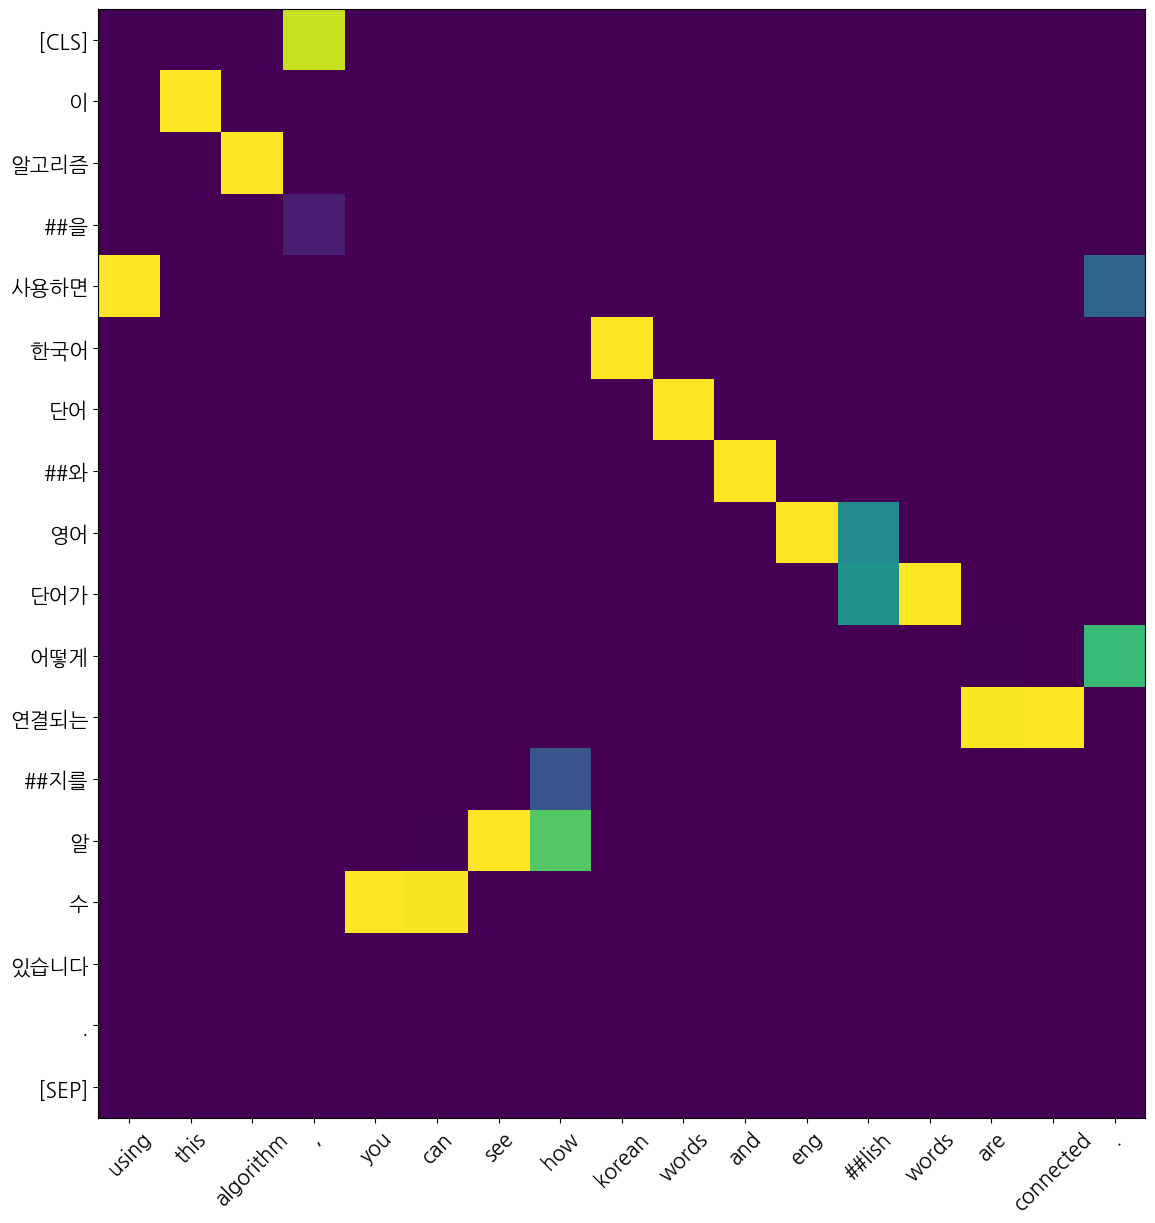

In [ ]:
plt.figure(figsize=(len(pred_tokens)*0.8, len(input_tokens)*0.8))
x_axis_label = [model.tgt_tokenizer.decode(x) for x in pred_tokens]
y_axis_label = [model.src_tokenizer.decode(x) for x in input_tokens]

plt.imshow(att_weights.detach())
plt.xticks(range(len(x_axis_label)), x_axis_label, fontsize=15,rotation = 45)
plt.yticks(range(len(y_axis_label)), y_axis_label, fontsize=15)
None

## Problem 4: TransSelf Attention (14 pts)
- In this problem, you will implement the query-key-value calculation that was used for Transformer
- Also, you have to implement self-attention and cross-attention, which are the core components of Transformer


### 4-1 Implement Query-Key-Value Calculation (2 pts)

In [ ]:
def get_query_key_value(input_tensor, qkv_layer):
  '''
  This function returns key, query, and value that is calculated by input tensor and nn_layer.

  Arguments:
    input_tensor (torch.Tensor): Has a shape of [N, T, C]
    kqv_layer (torch.nn.Linear): Linear layer with in_features=C and out_features=Cn * 3

  Outputs:
    queries (torch.Tensor): Has a shape of [N, T, Cn]
    keys (torch.Tensor): Has a shape of [N, T, Cn]
    values (torch.Tensor): Has a shape of [N, T, Cn]

  TODO: Complete this function without using for loop
  Hint: Use torch.chunk() to split a tensor into given number of chunks
  '''

  qkv = qkv_layer(input_tensor)
  queries, keys, values = torch.chunk(qkv, 3, dim=-1)

  return queries, keys, values

torch.manual_seed(0)
test = torch.randn(4, 17, 8)
linear = nn.Linear(8, 16 * 3)
queries, keys, values = get_query_key_value(test, linear)

In [ ]:
'''
Test cases
'''
answer = torch.Tensor([ 0.5393,  0.0587,  0.6597, -1.1150, -0.7343,  0.3282,  0.0551,  0.0178,
         0.4408, -0.3078,  0.3289, -0.4874,  0.2256, -0.1007, -0.4304, -0.2109])
answer2 = torch.Tensor([ 0.8704, -0.2256,  0.6611,  0.0332, -0.5233, -0.1159,  0.1805,  0.7238,
         0.5590,  0.7260,  1.3096,  0.2465,  1.1961,  0.1751, -0.9674,  0.6297])
assert keys.ndim == queries.ndim == values.ndim == 3
assert keys.shape == queries.shape == values.shape == torch.Size([4, 17, 16])
assert not (keys==queries).any() and not (keys==values).any() and not (values==queries).any()
assert torch.allclose(queries[2, 13], answer, atol=1e-4)
assert torch.allclose(values[0, 3], answer2, atol=1e-4)

print('Passed all the cases!')

Passed all the cases!


### 4-2 Implement 3d masked softmax (1 pts):
  - This would be almost similar to ``get_masked_softmax()``
  - It is common to use N x Tq x Tk attention score and mask, but we will use N x Tk x Tq

In [ ]:
def get_3d_masked_softmax(attention_score, mask):
  '''
  During the batch computation, each sequence in the batch can have different length.
  To group them as in a single tensor, we usually pad values

  Arguments:
    attention_score (torch.Tensor): The attention score in real number that represent how much does query have to attend to each vector in keys
                                    Has a shape of [N, Tk, Tq]
    mask (torch.Tensor): Boolean tensor with a shape of [N, Tk, Tq] that represents whether the corresponding is valid or not.
                         mask[n, tk, tq] == 1 if and only if input_batch[n,tk] is not a padded value.
                         If input_batch[n,tk] is a padded value, then mask[n,tk, tq] == 0

  Output:
    attention_weight (torch.Tensor): The attention weight in real number between 0 and 1. The sum of attention_weight along keys timestep dimension is 1.
                                    Has a shape of [N, Tk, Tq]

    attention_weight[n, i, t] has to be an attention weight of values[n, i] for queries[n, t]

  TODO: Complete this function without using for loop

  '''
  assert attention_score.ndim == 3 and mask.ndim == 3

  masked_attention_score = attention_score.masked_fill(mask == 0, float('-inf'))
  attention_weight = torch.softmax(masked_attention_score, dim=1)
  attention_weight = attention_weight * mask

  return attention_weight

'''
Don't change this codes
'''
torch.manual_seed(0)
mask = torch.ones([3, 9, 9])
mask[1, 2:] = 0
mask[2, 7:] = 0
att_score = torch.randn([3, 9, 9])
att_score_modified = att_score.clone()
att_score_modified[1, 2:] = 0
attention_weight = get_3d_masked_softmax(att_score, mask)
attention_weight_for_modified = get_3d_masked_softmax(att_score_modified, mask)
attention_weight, attention_weight_for_modified

(tensor([[[0.0184, 0.0284, 0.0529, 0.0524, 0.1245, 0.0395, 0.0352, 0.0184,
           0.0950],
          [0.0161, 0.1276, 0.0925, 0.0911, 0.1836, 0.0604, 0.0377, 0.0395,
           0.0126],
          [0.1001, 0.1988, 0.1237, 0.0171, 0.0379, 0.1260, 0.1022, 0.0850,
           0.0579],
          [0.0682, 0.3607, 0.3320, 0.2082, 0.0229, 0.0107, 0.0498, 0.0933,
           0.0882],
          [0.0881, 0.1006, 0.1290, 0.1256, 0.0481, 0.0436, 0.0361, 0.1610,
           0.1161],
          [0.5675, 0.0207, 0.0139, 0.0412, 0.1275, 0.0568, 0.0577, 0.1213,
           0.0465],
          [0.0977, 0.0606, 0.0435, 0.1700, 0.2438, 0.5983, 0.0104, 0.0445,
           0.4247],
          [0.0327, 0.0509, 0.1705, 0.2454, 0.1935, 0.0045, 0.6289, 0.0952,
           0.0963],
          [0.0111, 0.0519, 0.0421, 0.0490, 0.0183, 0.0602, 0.0419, 0.3419,
           0.0627]],
 
         [[0.9288, 0.3125, 0.7400, 0.8580, 0.3933, 0.5816, 0.2162, 0.7529,
           0.8763],
          [0.0712, 0.6875, 0.2600, 0.1420, 0.60

In [ ]:
'''
Test cases
'''

answer = torch.tensor([0.1348, 0.1429, 0.2938, 0.0369, 0.0748, 0.0577, 0.2591, 0.0000, 0.0000])

assert attention_weight.ndim == 3
assert torch.allclose(attention_weight[2,:, 0], answer, atol=1e-4)
assert not torch.isnan(attention_weight).any(), "Error: There is a nan value in attention_weight"
assert torch.allclose(attention_weight, attention_weight_for_modified, atol=1e-4), "Error: The attention_weight are different even though only masked item is different"

print('Passed all the cases!')

Passed all the cases!


### 4-3 Implement Self-Attention (2 pts)

In [ ]:
def get_self_attention(input_tensor, qkv_layer, mask):
  '''
  This function returns output of self-attention for a given input tensor using with a given kqv_layer

  Arguments:
    input_tensor (torch.Tensor): Has a shape of [N, T, C]
    kqv_layer (torch.nn.Linear): Linear layer with in_features=C and out_features=Cn * 3
    mask (torch.Tensor):

  Outputs:
    output (torch.Tensor): Has a shape of [N, T, Cn]

  TODO: Complete this function using your completed functions of below:
        get_query_key_value()
        get_attention_score_for_a_batch_multiple_query()
        get_3d_masked_softmax()
        get_batch_weighted_sum()
  '''
  queries, keys, values = get_query_key_value(input_tensor, qkv_layer)
  attention_scores = get_attention_score_for_a_batch_multiple_query(keys, queries)
  attention_weights = get_3d_masked_softmax(attention_scores, mask)
  output = get_batch_weighted_sum(values, attention_weights)

  return output


torch.manual_seed(0)
test = torch.randn(5, 17, 8)
linear = nn.Linear(8, 16 * 3)
mask = torch.ones([5, 17, 17])
mask[2, 4:] = 0
mask[4, 14:] = 0

att_vecs = get_self_attention(test, linear, mask)
modified_test = test.clone()
modified_test[2, 4:] = 0
modified_test[4, 14:] = 0
modified_att_vecs = get_self_attention(modified_test, linear, mask)

In [ ]:
'''
Test cases
'''
answer = torch.Tensor([-0.3925, -0.0043,  0.0343, -0.6713,  0.2388, -0.4703, -0.2195, -0.1550,
        -0.0830, -0.4170, -0.1829,  0.3884,  0.2899,  0.1284,  0.0225, -0.5960])
answer2 = torch.Tensor([-0.4078,  0.0173,  0.2670, -0.7959, -0.0314, -0.3455,  0.5751, -0.5806,
        -0.3328, -0.2571, -0.4913, -0.1833,  0.6236, -0.5167,  0.3256, -0.9818])
assert torch.allclose(att_vecs[3, 2], answer, atol=1e-4)
assert torch.allclose(att_vecs[0, 11], answer2, atol=1e-4)
assert torch.allclose(att_vecs[4, :14], modified_att_vecs[4, :14], atol=1e-6)


print('Passed all the cases!')

Passed all the cases!


### 4-4 Implement Multi-head split and concat (2 pts)

In [ ]:
def get_multihead_split(x, num_head):
  '''
  This function returns split tensor for multi-head attention

  Arguments:
    x (torch.Tensor): Has a shape of [N, T, C]
    num_head (int): Number of heads

  Output:
    x (torch.Tensor): Has a shape of [N * num_head, T, C // num_head]
    The order of N * num_head is [Batch1_head1, Batch1_head2, ..., Batch1_headN, Batch2_head1, Batch2_head2, ..., Batch2_headN, ...]
  '''
  assert x.shape[-1] % num_head == 0

  # TODO: Complete this function
  N, T, C = x.shape
  C_per_head = C // num_head
  x = x.view(N, T, num_head, C_per_head)
  x = x.transpose(1, 2)
  x = x.reshape(N * num_head, T, C_per_head)

  return x

torch.manual_seed(0)
dummy_input = torch.randn(4, 17, 32)
head_split_output = get_multihead_split(dummy_input, 8)
head_split_output.shape

assert head_split_output.shape == torch.Size([32, 17, 4])
assert (dummy_input[0, :, 4:8] == head_split_output[1]).all()
assert (dummy_input[0, 3, 8:12] == head_split_output[2, 3, :]).all()
assert (dummy_input[2, 10, 16:20] == head_split_output[20, 10, :]).all()
print('Passed all the cases!')


Passed all the cases!


In [ ]:
def get_multihead_concat(x, num_head):
  '''
  This function returns concat tensor for multi-head attention

  Arguments:
    x (torch.Tensor): Has a shape of [N * num_head, T, C // num_head]
    num_head (int): Number of heads
  Outputs:
    x (torch.Tensor): Has a shape of [N, T, C]
  '''
  # TODO: Complete this function
  # Ensure the input dimensions are compatible with the number of heads
  assert x.shape[0] % num_head == 0

  N = x.shape[0] // num_head
  T = x.shape[1]
  C_per_head = x.shape[2]

  x = x.view(N, num_head, T, C_per_head)
  x = x.permute(0, 2, 1, 3).contiguous()
  x = x.view(N, T, num_head * C_per_head)

  return x

head_cat_output = get_multihead_concat(head_split_output, 8)
print(f"Output shape: {head_cat_output.shape}")
assert head_cat_output.shape == torch.Size([4, 17, 32])
assert (dummy_input == head_cat_output).all()
print('Passed all the cases!')

Output shape: torch.Size([4, 17, 32])
Passed all the cases!


### 4-5 Implement Transformer-like multi-head self-attention (3 pts)

In [ ]:
import torch
import torch.nn as nn

def get_multi_head_self_attention(input_tensor, qkv_layer, output_proj_layer, mask, num_head=8):
    '''
    This function returns output of multi-headed self-attention for a given input tensor using with a given kqv_layer

    Arguments:
      input_tensor (torch.Tensor): Has a shape of [N, T, C]
      qkv_layer (torch.nn.Linear): Linear layer with in_features=C and out_features=Cn * 3
      output_proj_layer (torch.nn.Linear): Linear layer with in_features=Cn and out_features=C
      mask (torch.Tensor): Boolean tensor with a shape of [N, T, T] that represents whether the corresponding is valid or not.
                          mask[n, t] == 1 if and only if input_batch[n,t] is not a padded value.
                          If input_batch[n,t] is a padded value, then mask[n,t] == 0
      num_head (int): Number of heads

    Outputs:
      output (torch.Tensor): Has a shape of [N, T, Cn]

    TODO: Complete this function using your completed functions of below:
          get_query_key_value(): Get QKV from input_tensor and kqv_layer

          get_multihead_split(): Split QKV into multiple heads

          get_attention_score_for_a_batch_multiple_query(): Get attention score for a batch of multiple queries
            CAUTION: You have to scale the attention score by dividing by sqrt(Cn // num_head)
            HINT: att_score /= keys.shape[-1] ** 0.5

          get_3d_masked_softmax(): Get masked softmax/
            CAUTION: You have to repeat mask for num_head times to use it for multi-head attention
            USE head_repeated_mask
          get_batch_weighted_sum(): Get batch weighted sum

          get_multihead_concat(): Concatenate multiple heads into a single tensor

          Additionally, use output_proj_layer to project concatenated tensor at the final step
    '''

    head_repeated_mask = mask.unsqueeze(1).repeat(1, num_head, 1, 1).reshape(-1, mask.shape[1], mask.shape[2])
    keys, queries, values = get_query_key_value(input_tensor, qkv_layer)
    queries_splited = get_multihead_split(queries, num_head)
    keys_splited = get_multihead_split(keys, num_head)
    values_splited = get_multihead_split(values, num_head)
    att_scores = get_attention_score_for_a_batch_multiple_query(queries_splited, keys_splited)
    att_scores /= (keys_splited.shape[-1] ** 0.5)

    att_weights = get_3d_masked_softmax(att_scores, head_repeated_mask)
    attention_out = get_batch_weighted_sum(values_splited, att_weights)
    attention_out = get_multihead_concat(attention_out, num_head)
    output = output_proj_layer(attention_out)

    return output

In [ ]:
torch.manual_seed(0)
test = torch.randn(5, 17, 16)
linear = nn.Linear(16, 16 * 3)
out_proj = nn.Linear(16, 16)

mask = torch.ones([5, 17, 17])
mask[2, 4:] = 0
mask[4, 14:] = 0

att_vecs = get_multi_head_self_attention(test, linear, out_proj, mask, num_head=4)
att_vecs

tensor([[[ 0.0155,  0.2163,  0.1873,  ...,  0.2330, -0.0566, -0.0221],
         [ 0.0018,  0.2200,  0.2440,  ...,  0.2327, -0.0793, -0.0086],
         [-0.0333,  0.2005,  0.1883,  ...,  0.2249, -0.0467,  0.0511],
         ...,
         [ 0.0049,  0.1976,  0.2011,  ...,  0.2837, -0.0762, -0.0173],
         [-0.0048,  0.1969,  0.2040,  ...,  0.2370, -0.0491,  0.0220],
         [ 0.0070,  0.2108,  0.2147,  ...,  0.2444, -0.0692,  0.0032]],

        [[ 0.1762,  0.0831,  0.3563,  ...,  0.3361, -0.0043,  0.0481],
         [ 0.1654,  0.0404,  0.3476,  ...,  0.3637, -0.0096,  0.0640],
         [ 0.1985,  0.0251,  0.3585,  ...,  0.3495,  0.0224,  0.0492],
         ...,
         [ 0.1915, -0.0330,  0.3782,  ...,  0.3602,  0.0114,  0.0978],
         [ 0.1528,  0.1721,  0.3121,  ...,  0.2798,  0.0148,  0.0383],
         [ 0.1735,  0.0314,  0.3488,  ...,  0.3430,  0.0342,  0.0504]],

        [[ 0.0398, -0.0339,  0.2237,  ...,  0.1077,  0.1416,  0.3753],
         [ 0.0537, -0.2029,  0.3021,  ...,  0

In [ ]:
wrong_answer = torch.tensor([ 0.0105,  0.2337,  0.1587, -0.0346,  0.1446,  0.0231,  0.0296, -0.0437,
        -0.1101,  0.2079, -0.0813, -0.2343, -0.3270,  0.2156, -0.0427, -0.0313])
wrong_answer2 = torch.tensor([ 0.0557,  0.1026, -0.0834,  0.1770, -0.4083, -0.1543,  0.2025, -0.1570,
         0.0974, -0.0317,  0.0569, -0.0610,  0.0063,  0.0107, -0.0727,  0.0796])

assert not torch.allclose(att_vecs[0, 0], wrong_answer, atol=1e-4), "Error: You did not include attention score scaling. Read the CAUTION!"
assert not torch.allclose(att_vecs[0, 0], wrong_answer2, atol=1e-4), "Error: You did not include output projection. Read the TODO!"
print('Passed the test cases!')

Passed the test cases!


In [ ]:
'''
Compare with official implementation of PyTorch
'''

official_attention = torch.nn.MultiheadAttention(16, num_heads=4, batch_first=True)
official_attention.in_proj_weight.data = linear.weight.data
official_attention.in_proj_bias.data = linear.bias.data
official_attention.out_proj.weight.data = out_proj.weight.data
official_attention.out_proj.bias.data = out_proj.bias.data

head_repeated_mask = mask.unsqueeze(1).repeat(1, 4, 1, 1).reshape(-1, mask.shape[1], mask.shape[2]).transpose(1,2)
official_attention_output, attention_weights = official_attention(test, test, test, attn_mask=head_repeated_mask==0)

assert torch.allclose(att_vecs, official_attention_output, atol=1e-4), "Your output is different from the official output"
print('Passed the test cases!')

Passed the test cases!


### 4-6 Implement it as a single module (2 pts)

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, input_size, hidden_size, num_head, mask_value=0):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.qkv = nn.Linear(self.input_size, self.hidden_size * 3)
    self.out_proj = nn.Linear(self.hidden_size, self.input_size)
    self.mask_value = mask_value
    self.num_head = num_head
    assert self.hidden_size % self.num_head == 0
    self.dim_per_head = self.hidden_size // self.num_head

  def _get_qkv(self, x):
      return get_query_key_value(x, self.qkv)

  def _get_multihead_split(self, x):
      return get_multihead_split(x, self.num_head)

  def _get_multiheaded_att_score(self, keys, queries):
      att_scores = get_attention_score_for_a_batch_multiple_query(keys, queries)
      return att_scores / (self.dim_per_head ** 0.5)

  def _get_masked_softmax(self, score, masks):
      head_repeated_mask = masks.unsqueeze(1).repeat(1, self.num_head, 1, 1).reshape(-1, masks.shape[1], masks.shape[2])
      return get_3d_masked_softmax(score, head_repeated_mask)

  def _get_weighted_sum(self, values, weights):
      return get_batch_weighted_sum(values, weights)

  def forward(self, x, mask=None):
      if mask is None:
          mask = torch.ones([x.shape[0], x.shape[1], x.shape[1]])

      queries, keys, values = self._get_qkv(x)

      queries = self._get_multihead_split(queries)
      keys = self._get_multihead_split(keys)
      values = self._get_multihead_split(values)

      att_scores = self._get_multiheaded_att_score(keys, queries)

      att_weights = self._get_masked_softmax(att_scores, mask)

      att_output = self._get_weighted_sum(values, att_weights)

      multihead_concated = get_multihead_concat(att_output, self.num_head)

      output = self.out_proj(multihead_concated)

      return output

torch.manual_seed(0)
attention_module = SelfAttention(512, 512, 8)
test = torch.randn(5, 17, 512)
mask = torch.ones([5, 17, 17])
mask[2, 4:] = 0
mask[4, 14:] = 0

out = attention_module(test, mask)
out.shape

torch.Size([5, 17, 512])

In [ ]:
'''
Test case
'''

official_attention = torch.nn.MultiheadAttention(512, num_heads=8, batch_first=True)
official_attention.in_proj_weight.data = attention_module.qkv.weight.data
official_attention.in_proj_bias.data = attention_module.qkv.bias.data
official_attention.out_proj.weight.data = attention_module.out_proj.weight.data
official_attention.out_proj.bias.data = attention_module.out_proj.bias.data

head_repeated_mask = mask.unsqueeze(1).repeat(1, 8, 1, 1).reshape(-1, mask.shape[1], mask.shape[2]).transpose(1,2)
official_attention_output, attention_weights = official_attention(test, test, test, attn_mask=head_repeated_mask==0)

assert torch.allclose(out, official_attention_output, atol=1e-4), "Your output is different from the official output"
print('Passed the test cases!')

Passed the test cases!


### Test your SelfAttention module on Encoder Layer

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_size, hidden_size):
    super().__init__()
    self.input_size = in_size
    self.layer = nn.Sequential(nn.Linear(in_size, hidden_size),
                              nn.ReLU(),
                              nn.Linear(hidden_size, in_size))
  def forward(self, x):
    return self.layer(x)

class PosEncoding(nn.Module):
  def __init__(self, size, max_t):
    super().__init__()
    self.size = size
    self.max_t = max_t
    self.register_buffer('encoding', self._prepare_emb())

  def _prepare_emb(self):
    dim_axis = 10000**(torch.arange(self.size//2) * 2 / self.size)
    timesteps = torch.arange(self.max_t)
    pos_enc_in = timesteps.unsqueeze(1) / dim_axis.unsqueeze(0)
    pos_enc_sin = torch.sin(pos_enc_in)
    pos_enc_cos = torch.cos(pos_enc_in)

    pos_enc = torch.stack([pos_enc_sin, pos_enc_cos], dim=-1).reshape([self.max_t, 512])
    return pos_enc

  def forward(self, x):
    return self.encoding[x]

class ResidualLayerNormModule(nn.Module):
  def __init__(self, submodule):
    super().__init__()
    self.submodule = submodule
    self.layer_norm = nn.LayerNorm(self.submodule.input_size)

  def forward(self, x, mask=None, y=None):
    if y is not None:
      res_x = self.submodule(x, y, mask)
    elif mask is not None:
      res_x = self.submodule(x, mask)
    else:
      res_x = self.submodule(x)
    x =  x + res_x
    return self.layer_norm(x)

class EncoderLayer(nn.Module):
  def __init__(self, in_size, emb_size, mlp_size, num_head):
    super().__init__()
    self.att_block = ResidualLayerNormModule(SelfAttention(in_size, emb_size, num_head))
    self.mlp_block = ResidualLayerNormModule(MLP(emb_size, mlp_size))

  def forward(self, x):
    out = self.mlp_block(self.att_block(x['input'], x['mask']))
    return {'input':out, 'mask':x['mask']}


torch.manual_seed(0)
encoder_layer = EncoderLayer(512, 512, 2048, 8)
test = torch.randn(5, 17, 512)
mask = torch.ones([5, 17, 17])
mask[2, 4:] = 0
mask[4, 14:] = 0

out = encoder_layer({'input':test, 'mask':mask})

In [ ]:
'''
Test case
'''

official_encoder_layer = nn.TransformerEncoderLayer(512, 8, 2048, batch_first=True, dropout=0)

official_encoder_layer.self_attn.in_proj_weight.data = encoder_layer.att_block.submodule.qkv.weight.data
official_encoder_layer.self_attn.in_proj_bias.data = encoder_layer.att_block.submodule.qkv.bias.data
official_encoder_layer.self_attn.out_proj.weight.data = encoder_layer.att_block.submodule.out_proj.weight.data
official_encoder_layer.self_attn.out_proj.bias.data = encoder_layer.att_block.submodule.out_proj.bias.data
official_encoder_layer.linear1.weight.data = encoder_layer.mlp_block.submodule.layer[0].weight.data
official_encoder_layer.linear1.bias.data = encoder_layer.mlp_block.submodule.layer[0].bias.data
official_encoder_layer.linear2.weight.data = encoder_layer.mlp_block.submodule.layer[2].weight.data
official_encoder_layer.linear2.bias.data = encoder_layer.mlp_block.submodule.layer[2].bias.data
official_encoder_layer.norm1.weight.data = encoder_layer.att_block.layer_norm.weight.data
official_encoder_layer.norm1.bias.data = encoder_layer.att_block.layer_norm.bias.data
official_encoder_layer.norm2.weight.data = encoder_layer.mlp_block.layer_norm.weight.data
official_encoder_layer.norm2.bias.data = encoder_layer.mlp_block.layer_norm.bias.data

head_repeated_mask = mask.unsqueeze(1).repeat(1, 8, 1, 1).reshape(-1, mask.shape[1], mask.shape[2]).transpose(1,2)
official_encoder_output = official_encoder_layer(test, src_mask=head_repeated_mask==0)

assert torch.allclose(official_encoder_output, out['input'], atol=1e-4), "Your output is different from the official output"
print('Passed the test case!')

Passed the test case!


### 4-7 Implement Transformer-like multi-head cross-attention (2 pts)
- Implement ``CrossAttention`` inheriting `SelfAttention` class

In [ ]:
class CrossAttention(SelfAttention):
  def __init__(self, input_size, hidden_size, num_head, mask_value=0):
    super().__init__(input_size, hidden_size, num_head, mask_value)

  def forward(self, q_seq, kv_seq, mask=None):
      '''
      Arguments:
        q_seq (torch.Tensor): Sequence to be used for query
        kv_seq (torch.Tensor): Sequence to be used for key and value
        mask (torch.Tensor): Masking tensor. If the mask value is 0, the attention weight has to be zero. Shape: [N, Ty, Tx]

      Outputs:
        output (torch.Tensor): Output of cross attention. Shape: [N, Tx, C]
      '''
      if mask is None:
          mask = torch.ones([q_seq.shape[0], kv_seq.shape[1], q_seq.shape[1]])

      queries = self.qkv(q_seq)[:, :, :self.hidden_size]
      keys, values = self.qkv(kv_seq)[:, :, self.hidden_size:].chunk(2, dim=-1)

      queries = self._get_multihead_split(queries)
      keys = self._get_multihead_split(keys)
      values = self._get_multihead_split(values)

      att_scores = self._get_multiheaded_att_score(keys, queries)
      att_weights = self._get_masked_softmax(att_scores, mask)
      att_output = self._get_weighted_sum(values, att_weights)

      multihead_concat = get_multihead_concat(att_output, self.num_head)
      output = self.out_proj(multihead_concat)

      return output

class DecoderLayer(nn.Module):
  def __init__(self, in_size, emb_size, mlp_size, num_head):
    super().__init__()
    self.att_block = ResidualLayerNormModule(SelfAttention(in_size, emb_size, num_head))
    self.cross_att_block = ResidualLayerNormModule(CrossAttention(in_size, emb_size, num_head))
    self.mlp_block = ResidualLayerNormModule(MLP(emb_size, mlp_size))

  def forward(self, x):
    out = self.att_block(x['input'], x['decoder_mask'])
    out = self.cross_att_block(out,  x['encoder_mask'], x['encoder_out'])
    out = self.mlp_block(out)
    return {'input':out, 'decoder_mask':x['decoder_mask'], 'encoder_out':x['encoder_out'], 'encoder_mask':x['encoder_mask']}

torch.manual_seed(0)

decoder_layer = DecoderLayer(512, 512, 2048, 8)
test_src = torch.randn(5, 17, 512)
test_tgt = torch.randn(5, 19, 512)
mask_src = torch.ones([5, 17, 19])
mask_src[2, 4:] = 0
mask_src[4, 14:] = 0
mask_tgt = torch.tril(torch.ones(test_tgt.shape[0], test_tgt.shape[1], test_tgt.shape[1]))

out = decoder_layer({'input':test_tgt, 'decoder_mask':mask_tgt, 'encoder_out':test_src, 'encoder_mask':mask_src})
out['input'].shape

torch.Size([5, 19, 512])

In [ ]:
official_decoder_layer = nn.TransformerDecoderLayer(512, 8, 2048, batch_first=True, dropout=0)
official_decoder_layer.self_attn.in_proj_weight.data = decoder_layer.att_block.submodule.qkv.weight.data
official_decoder_layer.self_attn.in_proj_bias.data = decoder_layer.att_block.submodule.qkv.bias.data
official_decoder_layer.self_attn.out_proj.weight.data = decoder_layer.att_block.submodule.out_proj.weight.data
official_decoder_layer.self_attn.out_proj.bias.data = decoder_layer.att_block.submodule.out_proj.bias.data
official_decoder_layer.multihead_attn.in_proj_weight.data = decoder_layer.cross_att_block.submodule.qkv.weight.data
official_decoder_layer.multihead_attn.in_proj_bias.data = decoder_layer.cross_att_block.submodule.qkv.bias.data
official_decoder_layer.multihead_attn.out_proj.weight.data = decoder_layer.cross_att_block.submodule.out_proj.weight.data
official_decoder_layer.multihead_attn.out_proj.bias.data = decoder_layer.cross_att_block.submodule.out_proj.bias.data
official_decoder_layer.linear1.weight.data = decoder_layer.mlp_block.submodule.layer[0].weight.data
official_decoder_layer.linear1.bias.data = decoder_layer.mlp_block.submodule.layer[0].bias.data
official_decoder_layer.linear2.weight.data = decoder_layer.mlp_block.submodule.layer[2].weight.data
official_decoder_layer.linear2.bias.data = decoder_layer.mlp_block.submodule.layer[2].bias.data
official_decoder_layer.norm1.weight.data = decoder_layer.att_block.layer_norm.weight.data
official_decoder_layer.norm1.bias.data = decoder_layer.att_block.layer_norm.bias.data
official_decoder_layer.norm2.weight.data = decoder_layer.cross_att_block.layer_norm.weight.data
official_decoder_layer.norm2.bias.data = decoder_layer.cross_att_block.layer_norm.bias.data
official_decoder_layer.norm3.weight.data = decoder_layer.mlp_block.layer_norm.weight.data
official_decoder_layer.norm3.bias.data = decoder_layer.mlp_block.layer_norm.bias.data

# Mask for self-attentionq
# In nn.TransformerEncoderLayer or nn.TransformerDecoderLayer, the mask is expected to be [N, Tq, Tk]
# where N is the batch size, Tt is the query sequence length, and Ts is the key sequence length.
head_repeated_mask_src = mask_src.unsqueeze(1).repeat(1, 8, 1, 1).reshape(-1, mask_src.shape[1], mask_src.shape[2]).transpose(1,2)
head_repeated_mask_tgt = mask_tgt.unsqueeze(1).repeat(1,8,1,1).reshape(-1, mask_tgt.shape[1], mask_tgt.shape[2]).transpose(1,2)
official_decoder_output = official_decoder_layer(test_tgt, test_src, tgt_mask=head_repeated_mask_tgt==0, memory_mask=head_repeated_mask_src==0)

assert torch.allclose(official_decoder_output, out['input'], atol=1e-4), "Your output is different from the official output"
print('Passed the test cases!')

Passed the test cases!


### Using your implementation, we can build Transformer!

In [ ]:
class Encoder(nn.Module):
  def __init__(self, in_size, emb_size, mlp_size, num_head, num_layers, vocab_size):
    super().__init__()
    self.layers = nn.Sequential()
    for i in range(num_layers):
      self.layers.append(EncoderLayer(in_size,emb_size,mlp_size,num_head))
    self.pos_enc = PosEncoding(emb_size, 10000)
    self.token_emb = nn.Embedding(vocab_size, emb_size)

  def forward(self, x):
    mask = torch.ones([x.shape[0], x.shape[1], x.shape[1]])
    mask[x==0] = 0
    temp = torch.ones_like(x)
    result = torch.arange(x.shape[-1]).to(x.device) * temp
    x = self.token_emb(x) + self.pos_enc(result)
    return self.layers({'input':x, 'mask':mask})


class Decoder(nn.Module):
  def __init__(self, in_size, emb_size, mlp_size, num_head, num_layers, vocab_size):
    super().__init__()
    self.layers = nn.Sequential()
    for i in range(num_layers):
      self.layers.append(DecoderLayer(in_size,emb_size,mlp_size,num_head))
    self.pos_enc = PosEncoding(emb_size, 10000)
    self.token_emb = nn.Embedding(vocab_size, emb_size)

  def forward(self, x, y):
    mask = torch.triu(torch.ones(x.shape[0], x.shape[1], x.shape[1]))
    cross_attention_mask = torch.ones(x.shape[0], y['input'].shape[1], x.shape[1]) # N, Tk, Tq
    cross_attention_mask[y['mask'][:,:, 0]==0] = 0

    temp = torch.ones_like(x)
    result = torch.arange(x.shape[-1]).to(x.device) * temp
    x = self.token_emb(x) + self.pos_enc(result)
    return self.layers({'input':x, 'decoder_mask':mask, 'encoder_out':y['input'], 'encoder_mask':cross_attention_mask})

class TransformerTranslator(nn.Module):
  def __init__(self, in_size, emb_size, mlp_size, num_head, num_enc_layers, num_dec_layers, enc_vocab_size, dec_vocab_size):
    super().__init__()
    self.encoder = Encoder(in_size, emb_size, mlp_size, num_head, num_enc_layers, enc_vocab_size)
    self.decoder = Decoder(in_size, emb_size, mlp_size, num_head, num_dec_layers, dec_vocab_size)
    self.final_proj = nn.Linear(emb_size, dec_vocab_size)

  def forward(self, x:torch.Tensor, y:torch.Tensor):
    '''
    Arguments:
    '''
    enc_out = self.encoder(x)
    dec_out = self.decoder(y, enc_out)
    return self.final_proj(dec_out['input']).softmax(dim=-1)

class TransformerTrainer(Trainer):
  def __init__(self, model, optimizer, loss_fn, train_loader, valid_loader, device):
    super().__init__(model, optimizer, loss_fn, train_loader, valid_loader, device)
    self.num_iter = 0
    self._adjust_optim()

  def _adjust_optim(self):
    self.num_iter += 1
    self.optimizer.param_groups[0]['lr'] = 512 ** (-0.5) * min(self.num_iter**(-0.5), self.num_iter*4000**(-1.5))

  def _train_by_single_batch(self, batch):
    '''
    This method updates self.model's parameter with a given batch

    batch (tuple): (batch_of_input_text, batch_of_label)

    You have to use variables below:

    self.model (Translator/torch.nn.Module): A neural network model
    self.optimizer (torch.optim.adam.Adam): Adam optimizer that optimizes model's parameter
    self.loss_fn (function): function for calculating BCE loss for a given prediction and target
    self.device (str): 'cuda' or 'cpu'

    output: loss (float): Mean binary cross entropy value for every sample in the training batch
    The model's parameters, optimizer's steps has to be updated inside this method
    '''

    src, tgt_i, tgt_o = batch
    pred = self.model(src.to(self.device), tgt_i.to(self.device))
    pred = pack_padded_sequence(pred, pad_packed_sequence(tgt_o)[1], batch_first=True, enforce_sorted=False)
    loss = self.loss_fn(pred.data, tgt_o.data)
    loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()
    self._adjust_optim()

    return loss.item()

  def validate(self, external_loader=None):
    '''
    This method calculates accuracy and loss for given data loader.
    It can be used for validation step, or to get test set result

    input:
      data_loader: If there is no data_loader given, use self.valid_loader as default.


    output:
      validation_loss (float): Mean Binary Cross Entropy value for every sample in validation set
      validation_accuracy (float): Mean Accuracy value for every sample in validation set

    '''

    if external_loader and isinstance(external_loader, DataLoader):
      loader = external_loader
      print('An arbitrary loader is used instead of Validation loader')
    else:
      loader = self.valid_loader

    self.model.eval()


    validation_loss = 0
    num_correct_guess = 0
    num_data = 0
    with torch.inference_mode():
      for batch in tqdm(loader, leave=False):
        src, tgt_i, tgt_o = batch
        tgt_o = tgt_o.to(self.device)
        pred = self.model(src.to(self.device), tgt_i.to(self.device))
        pred = pack_padded_sequence(pred, pad_packed_sequence(tgt_o)[1], batch_first=True, enforce_sorted=False)
        loss = self.loss_fn(pred.data, tgt_o.data)

        if isinstance(pred, PackedSequence):
          loss = self.loss_fn(pred.data, tgt_o.data)
        else:
          loss = self.loss_fn(pred, tgt_o)

        validation_loss += loss.item() * len(pred.data)
        if isinstance(pred, PackedSequence):
          num_correct_guess += (pred.data.argmax(dim=-1) == tgt_o.data).sum().item()
        else:
          num_correct_guess += (pred.argmax(dim=-1) == tgt_o.data).sum().item()
        num_data += len(pred.data)
    return validation_loss / num_data, num_correct_guess / num_data

def pad_collate(raw_batch):
  srcs = [x[0] for x in raw_batch]
  tgts_i = [x[1][:-1] for x in raw_batch]
  tgts_o = [x[1][1:] for x in raw_batch]

  srcs = pad_sequence(srcs, batch_first=True)
  tgts_i = pad_sequence(tgts_i, batch_first=True)
  tgts_o = pack_sequence(tgts_o, enforce_sorted=False)
  return srcs, tgts_i, tgts_o

single_loader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
train_loader = DataLoader(trainset, batch_size=4, collate_fn=pad_collate, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(validset, batch_size=128, collate_fn=pad_collate, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(testset, batch_size=128, collate_fn=pad_collate, shuffle=False, num_workers=0, pin_memory=True)

batch = next(iter(train_loader))
tfm_model = TransformerTranslator(512,512,2048,8,6,12,32000,32000)
out = tfm_model(batch[0], batch[1])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


#### Transformer Test

In [ ]:
# download pre-trained weight
!gdown 1nxbQPD4a2SVicLBfzrj2pRU4hAapeMmL

Downloading...
From (original): https://drive.google.com/uc?id=1nxbQPD4a2SVicLBfzrj2pRU4hAapeMmL
From (redirected): https://drive.google.com/uc?id=1nxbQPD4a2SVicLBfzrj2pRU4hAapeMmL&confirm=t&uuid=dd738df1-cd5e-4b47-af3a-b56ce3ca7e1b
To: /content/kor_eng_translator_tfm_model_best.pt
100% 1.46G/1.46G [00:14<00:00, 101MB/s]


In [ ]:
tfm_model = TransformerTranslator(512, 512, 2048, 8, 6, 12, 32000, 32000)
state_dict = torch.load('kor_eng_translator_tfm_model_best.pt', map_location=torch.device('cpu'))
tfm_model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [ ]:
def translate_tfm(model, source_sentence, src_tokenizer, tgt_tokenizer):
  '''

  Arguments:
    model (TranslatorAtt): Translator model with attention
    source_sentence (str): Sentence to translate

  Returns:
    input_tokens (list): Source sentence in a list of token in token_id
    predicted_tokens (list): Translated sentence in a list of token in token_id
    decoded_string (str): Translated sentence in string

  '''

  input_tokens = src_tokenizer.encode(source_sentence)
  input_tensor = torch.LongTensor(input_tokens).unsqueeze(0)
  enc_out = model.encoder(input_tensor)

  # Setup for 0th step
  current_decoder_token = torch.LongTensor([[2]]) # start of sentence token

  for i in range(50): # You can chage it to while True:
    decoder_out = model.decoder(current_decoder_token, enc_out)['input']
    logit = model.final_proj(decoder_out[0, -1])
    selected_token = torch.argmax(logit, dim=-1)
    current_decoder_token = torch.tensor(current_decoder_token[0].tolist() + [selected_token], dtype=torch.long).unsqueeze(0)
    if selected_token == 3: ## end of sentence token
      break
  predicted_tokens = current_decoder_token.squeeze().tolist()[1:-1]
  print(tgt_tokenizer.decode(predicted_tokens))
  return input_tokens, predicted_tokens, tgt_tokenizer.decode(predicted_tokens)

tfm_model.cpu()
tfm_model.eval()
input_tokens, pred_tokens, translated_string  = translate_tfm(tfm_model, '자연어 처리는 어렵다 집에 가고 싶다', src_tokenizer, tgt_tokenizer)


i want to go home because it's difficult to process natural language.


# Check Before Submission
- Copy and paste your code to the downloaded ``NLP_Assignment_4.py``
  - https://raw.githubusercontent.com/jdasam/aat3020/main/NLP_Assignment_4.py

In [ ]:
# Run this code after copy and paste your code to NLP_Assignment_4.py
!python NLP_Assignment_4_20191138.py

Problem 1 Passed!
Problem 2 Passed!
2024-06-26 09:34:30.727508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 09:34:30.741719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 09:34:30.743068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-26 09:34:34.126449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Problem 3 Passed!
Passed all the cases!
Output shape: torch.Size([4, 17, 32])
Problem 4 Passed!
